<a href="https://colab.research.google.com/github/cleitonmoya/CPS765_Trabalho2/blob/main/CPS765_Trab2_AnaliseCleiton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rede da Correlação da Covid-19 nos Municípios Brasileiros

In [6]:
!pip install geopandas
import numpy as np
import networkx as nx
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import random

## Importação das redes

In [7]:
#!wget 'https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/redes/S085.graphml'
#!wget 'https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/redes/S085.graphml'
G = nx.read_graphml('G085.graphml', node_type=int) # Rede completa
S = nx.read_graphml('S085.graphml', node_type=int) # Componente conexa

Base de dados de casos novos:

In [8]:
df_cn = pd.read_csv('https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/datasets/df_cn_mm7.csv', index_col=0, parse_dates=True)

Base de dados dos municípios:

In [9]:
df_mun = pd.read_csv('https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/datasets/municipios.csv', index_col=0, sep=';')

## 1 - Análise da Rede das Capitais

Visualização da rede:

/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


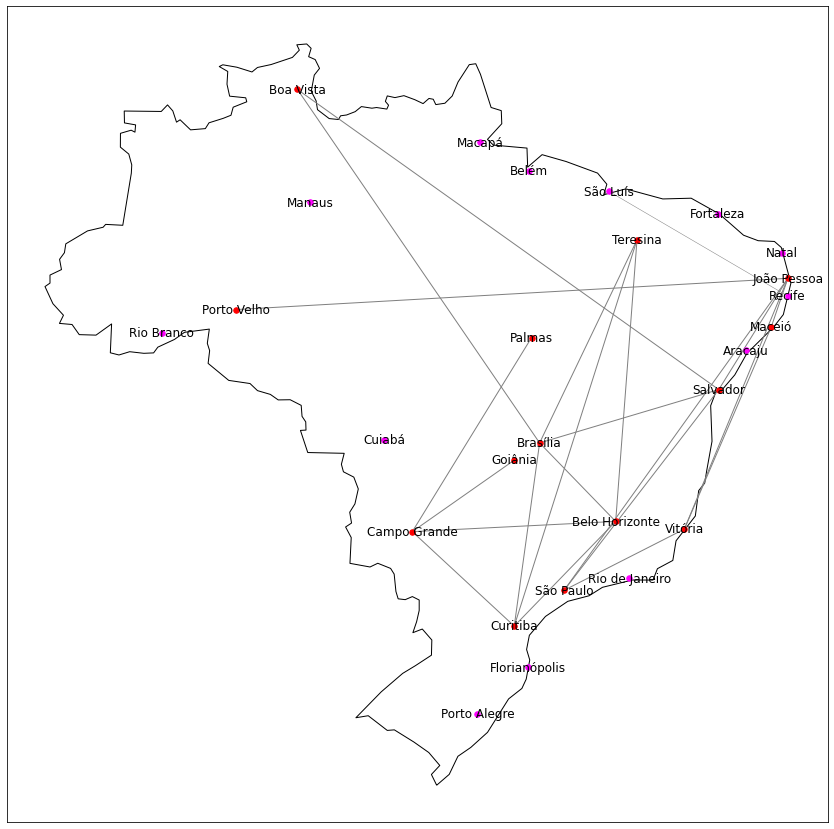

In [10]:
gdf = geopandas.GeoDataFrame()
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# mapa do Brasil.
ax = world[world.name == 'Brazil'].plot(
    color='white', edgecolor='black', figsize=(15,15))

# coordenadas das cidades
pos = {c: (att['longitude'], att['latitude']) for c,att in G.nodes(data=True) }

# Rótulos
capitais = [c for c,att in G.nodes(data=True) if att['capital']==True]
C = nx.subgraph(G, capitais)

# maior componente conexa
componentes = [c for c in nx.connected_components(C)]
maior_cc = max(nx.connected_components(C), key=len)

# Subgrafo do componente conexo
SC_cc = C.subgraph(maior_cc).copy()
labels1 = nx.get_node_attributes(SC_cc, 'city') 

# Componentes não conexas
componentes_nc = componentes.copy()
componentes_nc.remove(max(componentes,key=len))

# Subgrafos
SCs_nc = [C.subgraph(c).copy(c) for c in componentes_nc] 

# Plota a componente conexa
nx.draw_networkx(SC_cc, pos, node_size=30, node_color='red', edge_color='grey', width=1,with_labels=True, labels=labels1, ax=ax)

# Plota as demais componentes
for sc_nc in SCs_nc:
  labels2 = nx.get_node_attributes(sc_nc, 'city') 
  nx.draw_networkx(sc_nc, pos, node_size=30, node_color='magenta', edge_color='grey', width=0.5, with_labels=True, labels=labels2, ax=ax)

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')
plt.show()

Cálculo da distância das cidades:

In [11]:
from math import sin, cos, atan2, sqrt, radians
def calculaDist(cid1,cid2):
  lat1 = radians(cid1[0])
  lon1 = radians(cid1[1])
  lat2 = radians(cid2[0])
  lon2 = radians(cid2[1])

  dlat = lat2-lat1
  dlon = lon2-lon1

  # Fórmula de Haversine
  R = 6373.0 # Raio da terra (km)
  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  dist = R*c
  return dist

Adiciona as distâncias como atributo das arestas:

In [12]:
dist = {e:calculaDist((C.nodes[e[0]]['latitude'], C.nodes[e[0]]['longitude']),
               (C.nodes[e[1]]['latitude'], C.nodes[e[1]]['longitude'])) for e in C.edges}

In [13]:
nx.set_edge_attributes(C,dist,"dist")

In [14]:
C.edges[(1100205, 2507507)]

{'dist': 3203.149547181645, 'weight': 1}

### 1.1 Distribuição de Grau

In [15]:
degrees = np.array([val for (node, val) in SC_cc.degree()])
from statistics import median
print('Máximo:', degrees.max())
print('Mínimo:', degrees.min())
print('Média:',degrees.mean())
print('Mediana:', median(degrees))
print('Desvio padrão:', degrees.std())

Máximo: 5
Mínimo: 1
Média: 3.0
Mediana: 3.0
Desvio padrão: 1.3627702877384937


Capitais com maior grau:

In [16]:
x = {att['city']:val 
 for (node1, val) in SC_cc.degree()
 for (node2, att) in SC_cc.nodes(data=True)
 if node1==node2 and val!=0} 
sorted(x.items(), key=lambda item: item[1], reverse=True)

[('Brasília', 5),
 ('João Pessoa', 5),
 ('Campo Grande', 4),
 ('Salvador', 4),
 ('Curitiba', 4),
 ('Belo Horizonte', 4),
 ('São Paulo', 3),
 ('Teresina', 3),
 ('Vitória', 3),
 ('Boa Vista', 2),
 ('Maceió', 2),
 ('Goiânia', 1),
 ('Palmas', 1),
 ('Porto Velho', 1)]

Verificando o comportamento do covid nesta duas cidades: 

In [17]:
df_mun[df_mun['city']=='Brasília'].index

Int64Index([5300108], dtype='int64', name='cod')

In [18]:
df_mun[df_mun['city']=='João Pessoa'].index

Int64Index([2507507], dtype='int64', name='cod')

[]

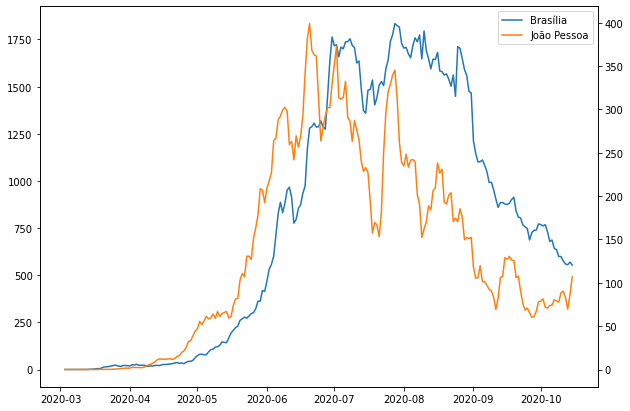

In [19]:
fig,ax1 = plt.subplots(figsize=(10,7))
l1 = ax1.plot(df_cn['5300108'], label=df_mun.loc[5300108].city)
ax2 = ax1.twinx()
l2 = ax2.plot(df_cn['2507507'], c='C1', label=df_mun.loc[2507507].city)
lns = l1+l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.plot()

### 1.2 Distâncias

In [20]:
length = nx.all_pairs_shortest_path_length(SC_cc)
dic_length = {c:d for c,d in length}

dic_dist = {c:{x:v[x] for x in v if x!=c}
  for c,v in dic_length.items()}

lista_dist = []
for dic in dic_dist.values():
  lista_dist = lista_dist + list(dic.values())

dist = np.array(lista_dist)

Estatísticas básicas:

In [21]:
print('Máximo:', dist.max())
print('Mínimo:', dist.min())
print('Média:',dist.mean())
print('Mediana:', median(dist))
print('Desvio padrão:', dist.std())

Máximo: 6
Mínimo: 1
Média: 2.791208791208791
Mediana: 3.0
Desvio padrão: 1.4863221332802519


Capitais com maiores distâncias entre si:

In [22]:
lista_dist2 = ([(c1,c2,d) 
  for c1, v in dic_dist.items()
  for c2, d in v.items()
  ])

In [23]:
lista_dist3 =  list(set(tuple(sorted(x)) for x in lista_dist2))

Capitais com menores distância:

In [24]:
sorted(lista_dist3)[:5]

[(1, 1100205, 2507507),
 (1, 1400100, 2927408),
 (1, 1400100, 5300108),
 (1, 1721000, 5002704),
 (1, 2211001, 3106200)]

[]

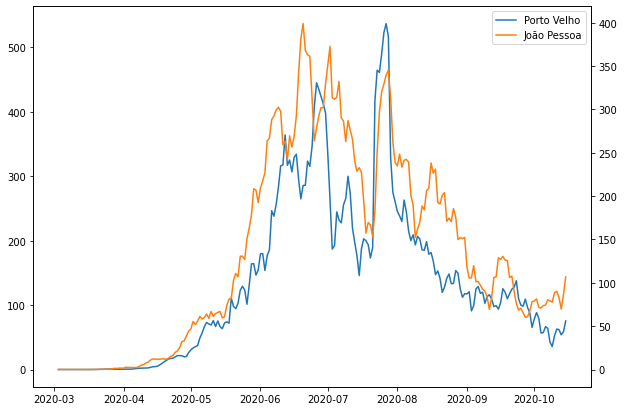

In [25]:
fig,ax1 = plt.subplots(figsize=(10,7))
l1 = ax1.plot(df_cn['1100205'], label=df_mun.loc[1100205].city)
ax2 = ax1.twinx()
l2 = ax2.plot(df_cn['2507507'], c='C1', label=df_mun.loc[2507507].city)
lns = l1+l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.plot()

Lista das 10 capitais  maiores distâncias entre si: 

In [26]:
sorted(lista_dist3,reverse=True)[:5]

[(6, 3205309, 5208707),
 (6, 2704302, 5208707),
 (6, 1721000, 3205309),
 (6, 1721000, 2704302),
 (6, 1100205, 5208707)]

Verificando o comportamento do Covid nestas cidades com maiores distância:

[]

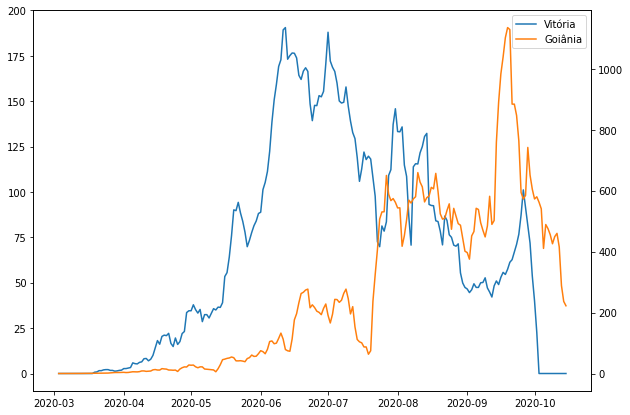

In [27]:
fig,ax1 = plt.subplots(figsize=(10,7))
l1 = ax1.plot(df_cn['3205309'], label=df_mun.loc[3205309].city)
ax2 = ax1.twinx()
l2=ax2.plot(df_cn['5208707'], c='C1', label=df_mun.loc[5208707].city)
lns = l1+l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.plot()

### 1.3 Assortatividade

In [28]:
df_mun

,regiao,uf,city,capital,population,idhf,pib,latitude,longitude
cod,,,,,,,,,
1100015,Norte,RO,Alta Floresta D'Oeste,False,22728,0.609139,19611.75,-11.92830,-61.9953
1100023,Norte,RO,Ariquemes,False,109523,0.753049,21389.67,-9.90571,-63.0325
1100031,Norte,RO,Cabixi,False,5188,0.591030,22315.80,-13.49450,-60.5520
1100049,Norte,RO,Cacoal,False,85893,0.748255,24037.91,-11.43430,-61.4562
1100056,Norte,RO,Cerejeiras,False,16204,0.663645,25009.71,-13.18700,-60.8168
...,...,...,...,...,...,...,...,...,...
5222005,Centro-oeste,GO,Vianópolis,False,13977,0.677555,28942.36,-16.74050,-48.5159
5222054,Centro-oeste,GO,Vicentinópolis,False,8873,0.664198,41772.71,-17.73220,-49.8047
5222203,Centro-oeste,GO,Vila Boa,False,6312,0.321381,23992.38,-15.03870,-47.0520


In [29]:
df_mun[['latitude', 'idhf']].corr()

,latitude,idhf
latitude,1.000000,-0.593723
idhf,-0.593723,1.000000


In [30]:
print(nx.attribute_assortativity_coefficient(S, "regiao"))

0.16779333504527302


In [31]:
print(nx.attribute_assortativity_coefficient(S, "uf"))

0.14540150664163026


In [32]:
(nx.attribute_mixing_matrix(S,'idhf')>0.05).sum()

0

#2. Análise da componente conexa

## 2.1 Distribuição de grau

### 2.1.1 Estatísticas Básicas

In [39]:
degrees = np.array([val for (node, val) in S.degree()])
from statistics import median
print('Máximo:', degrees.max())
print('Mínimo:', degrees.min())
print('Média:',degrees.mean())
print('Mediana:', median(degrees))
print('Desvio padrão:', degrees.std())

Máximo: 293
Mínimo: 1
Média: 28.501483679525222
Mediana: 11.0
Desvio padrão: 41.15215485768324


### 2.1.1 PMF

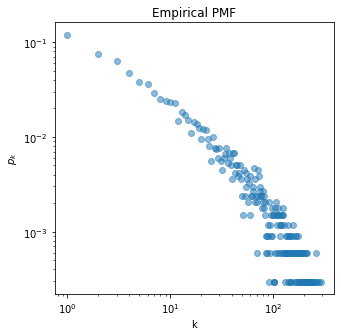

In [77]:
x, f = np.unique(degrees, return_counts=True)
pmf = f/f.sum()

plt.figure(figsize=(5,5))
plt.scatter(x,pmf,alpha=0.5)
plt.title('Empirical PMF')
plt.xlabel('k')
plt.ylabel('$p_k$')
plt.xscale('log')
plt.yscale('log')
plt.show()

### 2.1.2 CCDF

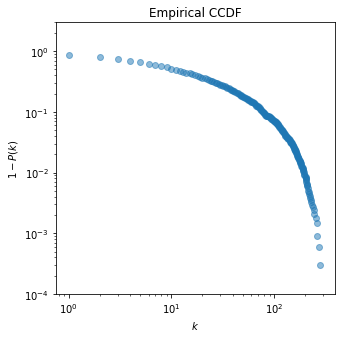

In [75]:
cdf = f.cumsum()/f.sum()
ccdf = 1-cdf

plt.figure(figsize=(5,5))
plt.scatter(x,ccdf,alpha=0.5)
plt.title('Empirical CCDF')
plt.xlabel('$k$')
plt.ylabel('$1-P(k)$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-4, 3*10**0)
plt.show()

Verificamos que a distribuição não segue é uma lei de potência.

### 2.1.3 Outras Análises

Top 10 cidades com maior grau:

In [43]:
x = {att['city']:val 
 for (node1, val) in S.degree()
 for (node2, att) in S.nodes(data=True)
 if node1==node2 and val>0} 
sorted(x.items(), key=lambda item: item[1], reverse=True)[:10]

[('São José do Rio Preto', 293),
 ('Barreiras', 281),
 ("Santa Bárbara d'Oeste", 270),
 ('Americana', 261),
 ('Santa Rosa', 261),
 ('Campina Grande do Sul', 259),
 ('Vinhedo', 253),
 ('Valinhos', 246),
 ('Atibaia', 245),
 ('São José dos Campos', 240)]

## 2.2 Distribuição de distâncias

In [78]:
length = nx.all_pairs_shortest_path_length(S)
dic_length = {c:d for c,d in length}
dic_dist = {c:{x:v[x] for x in v if x!=c}
  for c,v in dic_length.items()}
lista_dist = []
for dic in dic_dist.values():
  lista_dist = lista_dist + list(dic.values())
dist = np.array(lista_dist)

### 2.2.1 Estatísticas básicas

In [79]:
print('Máximo:', dist.max())
print('Mínimo:', dist.min())
print('Média:',dist.mean())
print('Mediana:', median(dist))
print('Desvio padrão:', dist.std())

Máximo: 18
Mínimo: 1
Média: 4.9948697893958975
Mediana: 5.0
Desvio padrão: 2.0870970627922163


### Distribuição empírica

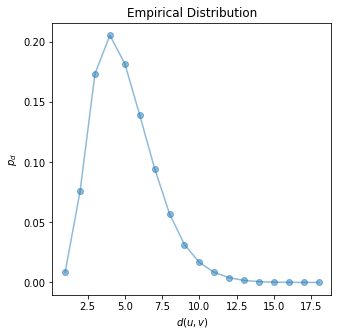

In [82]:
x, f_d = np.unique(dist, return_counts=True)
pmf = f_d/f_d.sum()

plt.figure(figsize=(5,5))
plt.title('Empirical Distribution')
plt.xlabel('$d(u,v)$')
plt.ylabel('$p_d$')

plt.scatter(x,pmf,alpha=0.5)
plt.plot(x,pmf, alpha=0.5)
plt.show()

## 2.3 Assortatividade

### 2.3.1 Assortatividade de grau

In [37]:
nx.degree_assortativity_coefficient(S)

0.31981102767524144

**Interpretação**: correlação positiva: *hubs* tendem a se conectar com hubs

### 2.3.2 Assortatividade 

# 2.4 Similaridade